<a href="https://colab.research.google.com/github/ertematakavaz03/screen-time-to-health/blob/main/analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Imports & File Existence**

In [82]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import os

# To standardize numeric columns:
from sklearn.preprocessing import StandardScaler

# To define file paths:
deadlines_path = "./Data/deadlines.json"
iphone_screen_time_path = "./Data/iPhoneScreenTime.json"
laptop_screen_time_path = "./Data/laptopScreenTime.json"
steps_kcal_path = "./Data/steps&kcal.json"

# To test the file paths:
print("Checking file existence...")
print("deadlines.json:", os.path.exists(deadlines_path))
print("iPhoneScreenTime.json:", os.path.exists(iphone_screen_time_path))
print("laptopScreenTime.json:", os.path.exists(laptop_screen_time_path))
print("steps&kcal.json:", os.path.exists(steps_kcal_path))


Checking file existence...
deadlines.json: True
iPhoneScreenTime.json: True
laptopScreenTime.json: True
steps&kcal.json: True


# **Part 2: Load the JSON Data**

In [83]:
print("\nLoading data from JSON files...")

with open(deadlines_path, "r") as f:
    deadlines_data = json.load(f)

with open(iphone_screen_time_path, "r") as f:
    iphone_json = json.load(f)

with open(laptop_screen_time_path, "r") as f:
    laptop_json = json.load(f)

with open(steps_kcal_path, "r") as f:
    steps_kcal_json = json.load(f)

print("Data loaded successfully.")



Loading data from JSON files...
Data loaded successfully.


# **Part 3: Parse iPhone Screen Time Data**

In [84]:
print("\nParsing iPhone Screen Time data (day, date, total_screen_time)...")

iphone_records = iphone_json["daily_records"]
iphone_df = pd.json_normalize(iphone_records)

# To make the merges consistent, I have renamed "date" to "Date":
iphone_df.rename(columns={"date": "Date"}, inplace=True)

# To make Hours to minutes
def hms_to_minutes(timestr):
    if not timestr or ":" not in timestr:
        return 0.0
    h, m, s = timestr.split(":")
    return int(h)*60 + int(m) + float(s)/60

iphone_df["total_screen_time_minutes"] = iphone_df["total_screen_time"].apply(hms_to_minutes)

print("iPhone DataFrame sample:")
print(iphone_df.head())



Parsing iPhone Screen Time data (day, date, total_screen_time)...
iPhone DataFrame sample:
         Date        day total_screen_time  total_screen_time_minutes
0  2024-11-04     Monday           4:26:00                      266.0
1  2024-11-05    Tuesday           5:59:00                      359.0
2  2024-11-06  Wednesday           3:15:00                      195.0
3  2024-11-07   Thursday           4:17:00                      257.0
4  2024-11-08     Friday           5:48:00                      348.0


# **Part 4: Parse Laptop Screen Time Data**

In [99]:
print("\nParsing Laptop screen time data...")

laptop_records = []
for date_str, usage_str in laptop_json.items():
    def parse_laptop_time(t_str):
        parts = t_str.split()
        if "hour" in parts[1]:
            hours = int(parts[0])
            minutes = 0
            if len(parts) >= 4 and "minute" in parts[3]:
                minutes = int(parts[2])
            return hours*60 + minutes
        else:
            return int(parts[0])

    laptop_minutes = parse_laptop_time(usage_str)
    laptop_records.append({"Date": date_str, "laptop_screen_time_minutes": laptop_minutes})

laptop_df = pd.DataFrame(laptop_records)
print("Laptop Data sample:")
print(laptop_df.head())



Parsing Laptop screen time data...
Laptop Data sample:
         Date  laptop_screen_time_minutes
0  2024-11-04                         154
1  2024-11-05                           0
2  2024-11-06                           0
3  2024-11-07                           0
4  2024-11-08                         367


# **Part 5: Parse Steps & Calories Data**

In [87]:
print("\nParsing Steps & Calories data...")

steps_kcal_records = []
for date_str, arr in steps_kcal_json.items():
    steps_val, kcal_val = arr[0], arr[1]
    steps_kcal_records.append({
        "Date": date_str,
        "steps": steps_val,
        "kcal_burned": kcal_val
    })

steps_kcal_df = pd.DataFrame(steps_kcal_records)
print("Steps & Calories Data sample:")
print(steps_kcal_df.head())



Parsing Steps & Calories data...
Steps & Calories Data sample:
         Date  steps  kcal_burned
0  2024-11-04   2823           94
1  2024-11-05   9285          365
2  2024-11-06   8080          324
3  2024-11-07   6286          213
4  2024-11-08  11246          370


# **Part 6: Parse deadlines**

In [88]:
print("\nParsing deadlines data...")

deadlines_records = []
for date_str, events in deadlines_data.items():
    deadlines_records.append({
        "Date": date_str,
        "deadlines_list": events,
        "num_deadlines": len(events)
    })

deadlines_df = pd.DataFrame(deadlines_records)
print("Deadlines Data sample:")
print(deadlines_df.head())



Parsing deadlines data...
Deadlines Data sample:
         Date                                     deadlines_list  \
0  2024-11-10  [Midterm Exam, DSA210, Midterm Exam, CS307, HW...   
1  2024-11-22                              [PA2 Deadline, CS307]   
2  2024-11-23                            [Midterm Exam, MATH306]   
3  2024-11-24                              [Midterm Exam, CS300]   
4  2024-11-30                         [Project Proposal, DSA210]   

   num_deadlines  
0              3  
1              1  
2              1  
3              1  
4              1  


# **Part 7: Merge all datasets**

In [89]:
print("\nMerging all datasets into a single DataFrame...")

merged_df = (
    iphone_df
    .merge(laptop_df, on="Date", how="outer")
    .merge(steps_kcal_df, on="Date", how="outer")
    .merge(deadlines_df, on="Date", how="outer")
)

merged_df["Date"] = pd.to_datetime(merged_df["Date"], format="%Y-%m-%d", errors="coerce")
merged_df.sort_values(by="Date", inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# To fill the days with no deadlines to 0
if "num_deadlines" in merged_df.columns:
    merged_df["num_deadlines"] = merged_df["num_deadlines"].fillna(0)

print("Merged DataFrame sample (columns):", merged_df.columns.tolist())
print(merged_df.head())



Merging all datasets into a single DataFrame...
Merged DataFrame sample (columns): ['Date', 'day', 'total_screen_time', 'total_screen_time_minutes', 'laptop_screen_time_minutes', 'steps', 'kcal_burned', 'deadlines_list', 'num_deadlines']
        Date        day total_screen_time  total_screen_time_minutes  \
0 2024-11-04     Monday           4:26:00                      266.0   
1 2024-11-05    Tuesday           5:59:00                      359.0   
2 2024-11-06  Wednesday           3:15:00                      195.0   
3 2024-11-07   Thursday           4:17:00                      257.0   
4 2024-11-08     Friday           5:48:00                      348.0   

   laptop_screen_time_minutes  steps  kcal_burned deadlines_list  \
0                       154.0   2823           94            NaN   
1                         0.0   9285          365            NaN   
2                         0.0   8080          324            NaN   
3                         0.0   6286          213       

# **Part 8: Standardize Numeric Columns**

In [90]:
print("\nStandardizing numeric columns...")

cols_to_scale = [
    "total_screen_time_minutes",
    "laptop_screen_time_minutes",
    "steps",
    "kcal_burned"
]
merged_df_clean = merged_df.dropna(subset=cols_to_scale, how="all").copy()

scaler = StandardScaler()
merged_df_clean[cols_to_scale] = scaler.fit_transform(merged_df_clean[cols_to_scale])

print("Standardized Data Sample:")
print(merged_df_clean[cols_to_scale].head())



Standardizing numeric columns...
Standardized Data Sample:
   total_screen_time_minutes  laptop_screen_time_minutes     steps  \
0                  -0.201928                   -0.229811 -1.394458   
1                   0.683642                   -1.050252  0.822877   
2                  -0.878008                   -1.050252  0.409400   
3                  -0.287628                   -1.050252 -0.206183   
4                   0.578897                    0.904956  1.495764   

   kcal_burned  
0    -1.392133  
1     0.870943  
2     0.528559  
3    -0.398384  
4     0.912697  


# **Part 9: Correlation Heatmap**


Generating correlation heatmap (standardized data)...


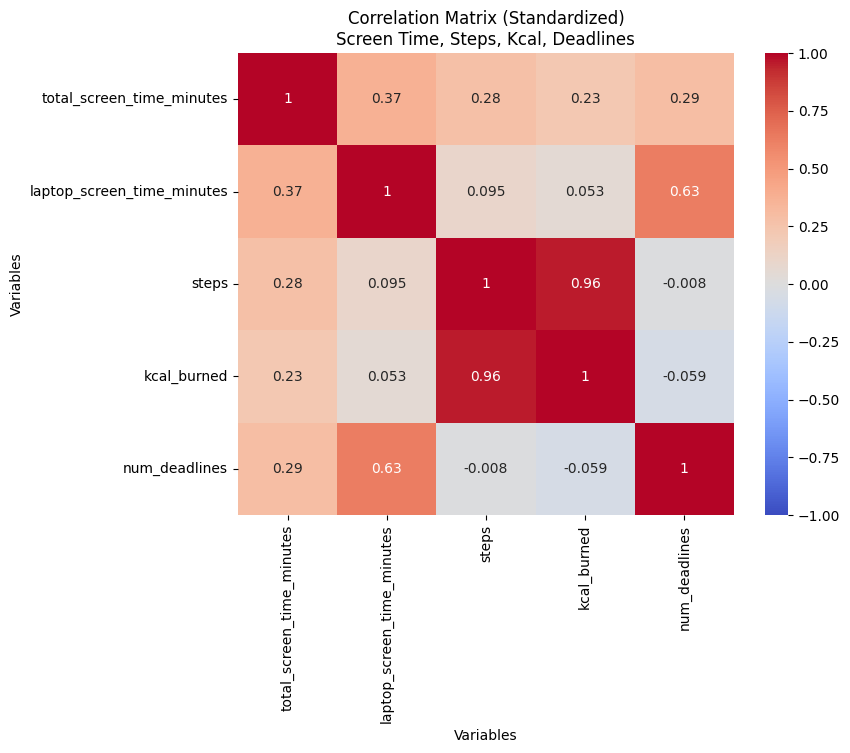

In [91]:
print("\nGenerating correlation heatmap (standardized data)...")

merged_df_clean["num_deadlines"] = merged_df_clean["num_deadlines"].fillna(0)

cols_for_corr = cols_to_scale + ["num_deadlines"]
corr_matrix = merged_df_clean[cols_for_corr].corr()

fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlation Matrix (Standardized)\nScreen Time, Steps, Kcal, Deadlines")
ax.set_xlabel("Variables")
ax.set_ylabel("Variables")
plt.show()




1.   **High Correlation (Close to +1):** Means as one variable increases, the other tends to increase proportionally.

Example: You can see steps and kcal_burned have ~0.96 correlation (a very strong positive relationship). This makes intuitive sense: more steps I take the more calories I burn.

2.  **Low / Negative Correlation (Close to 0 or negative):** Suggests little to no linear relationship.

Example: If num_deadlines is near 0 correlation with steps, that means having more deadlines doesn’t strongly predict my daily step count, but there could be other factors.

3.   **Moderate Correlation (~0.3 to 0.6):** Suggests a partial relationship but not extremely strong.

Example: total iPhone screen time vs. laptop screen time might be ~0.37, meaning they somewhat track each other (on days that I use my iPhone a lot, I also might use my laptop a bit more, but it’s not guaranteed.)

**Standardized Data:** The matrix was computed on z-scores (mean=0, std=1). This helps the comparisons by putting all variables on the same scale.





# **Part 10.1: Steps vs. iPhone & Laptop Screen Time**


Plot: Steps vs. iPhone & Laptop Screen Time Over Time (Dual Y-axis)


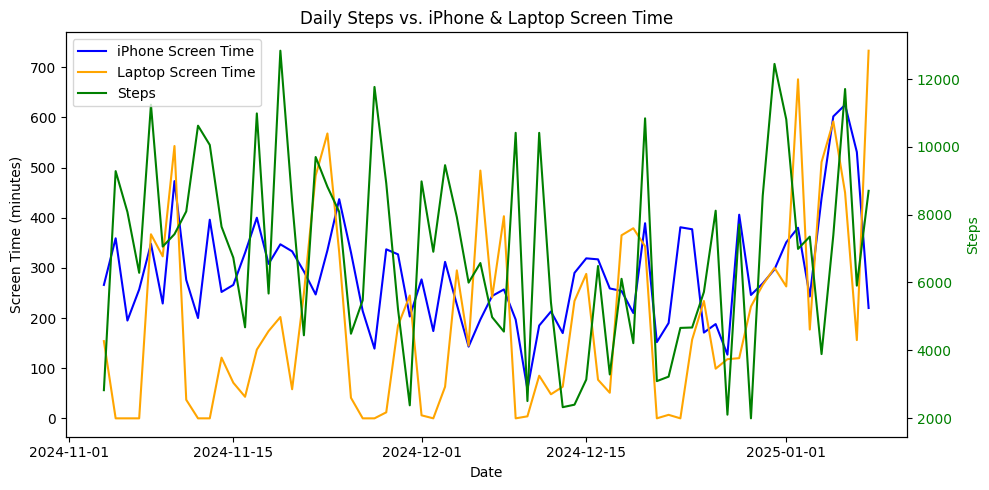

In [97]:
print("\nPlot: Steps vs. iPhone & Laptop Screen Time Over Time (Dual Y-axis)")

fig, ax1 = plt.subplots(figsize=(10,5))

plot_df = merged_df.dropna(
    subset=["Date", "steps", "total_screen_time_minutes", "laptop_screen_time_minutes"]
).copy()

# Colors
color_iphone = "blue"
color_laptop = "orange"
color_steps = "green"

# Left axis → iPhone + Laptop Screen Time
ax1.set_xlabel("Date")
ax1.set_ylabel("Screen Time (minutes)")
line1, = ax1.plot(
    plot_df["Date"],
    plot_df["total_screen_time_minutes"],
    color=color_iphone,
    label="iPhone Screen Time"
)
line2, = ax1.plot(
    plot_df["Date"],
    plot_df["laptop_screen_time_minutes"],
    color=color_laptop,
    label="Laptop Screen Time"
)

# Right axis → Steps
ax2 = ax1.twinx()
ax2.set_ylabel("Steps", color=color_steps)
line3, = ax2.plot(
    plot_df["Date"],
    plot_df["steps"],
    color=color_steps,
    label="Steps"
)
ax2.tick_params(axis='y', labelcolor=color_steps)

# Combined legend
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc="upper left")

plt.title("Daily Steps vs. iPhone & Laptop Screen Time")
plt.tight_layout()
plt.show()


How Physical Activity Relates to my Screen Time is a bit confusing. But don't get afraid when you look at the graph!

By plotting two screen-time lines on the left axis and steps on the right axis, one can visually see if on days that I have high total screen time, the fewer (can vary) I take steps.

When **the green line (steps)** generally peaks when the blue/orange lines are low, this might suggest an inverse relationship between my screen time and physical activity(the more screen time, fewer steps, or vice versa).

But what about my iPhone and Laptop screen times? The blue vs. orange lines let me see whether my daily usage is dominated by iPhone or laptop, and how that might track with my steps. After taking a peek to the graph, one can see the pattern that my Laptop usage generally dominate my step count more than my iPhone usage.

This may suggest that *I can keep my physical activities while using my iPhone better than my Laptop.* Or that *I do less physical activities when I am studying* (which the relation between laptop usage and studying will be explained).


# **Part 10.2: Deadlines vs. iPhone & Laptop Screen Time**


Plot: Deadlines vs. iPhone & Laptop Screen Time (Dual Y-axis)


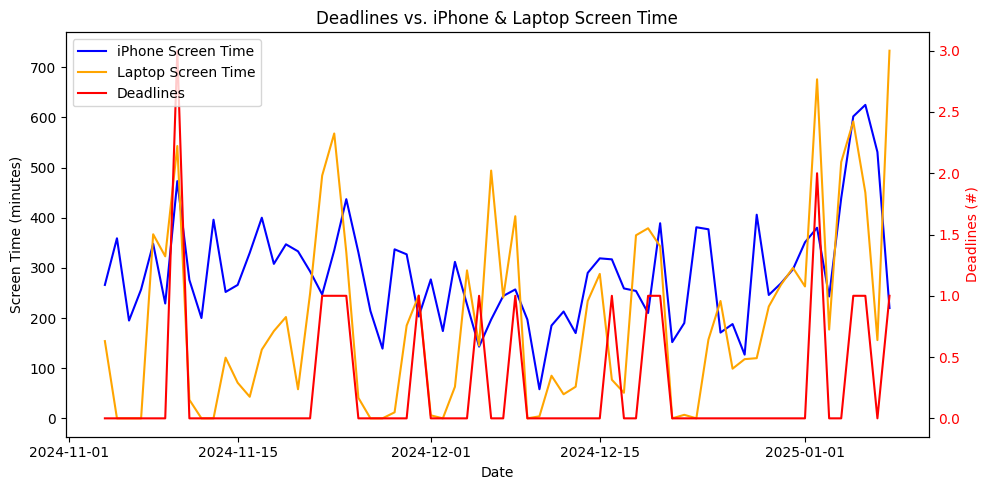

In [98]:
print("\nPlot: Deadlines vs. iPhone & Laptop Screen Time (Dual Y-axis)")

fig, ax1 = plt.subplots(figsize=(10,5))

plot_df2 = merged_df.dropna(
    subset=["Date", "num_deadlines", "total_screen_time_minutes", "laptop_screen_time_minutes"]
).copy()


color_iphone = "blue"
color_laptop = "orange"
color_deadlines = "red"


ax1.set_xlabel("Date")
ax1.set_ylabel("Screen Time (minutes)")
line1, = ax1.plot(
    plot_df2["Date"],
    plot_df2["total_screen_time_minutes"],
    color=color_iphone,
    label="iPhone Screen Time"
)
line2, = ax1.plot(
    plot_df2["Date"],
    plot_df2["laptop_screen_time_minutes"],
    color=color_laptop,
    label="Laptop Screen Time"
)


ax2 = ax1.twinx()
ax2.set_ylabel("Deadlines (#)", color=color_deadlines)
line3, = ax2.plot(
    plot_df2["Date"],
    plot_df2["num_deadlines"],
    color=color_deadlines,
    label="Deadlines"
)
ax2.tick_params(axis='y', labelcolor=color_deadlines)


lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc="upper left")

plt.title("Deadlines vs. iPhone & Laptop Screen Time")
plt.tight_layout()
plt.show()


On days with **multiple deadlines (the red line spiking)**, check if iPhone or laptop usage changes significantly.

For instance, one might see that on days with 2–3 deadlines, **my laptop screen time (orange)** is high, possibly because I'm working on assignments or studying. Or perhaps my iPhone time dips because I'm more busy with the deadlines at the moment.

Notice the *left axis* goes from 0 to 600–700 (minutes), while the *right axis* might go from 0 to 3 (deadlines). This means each line is plotted on a different scale. The deadlines can get max up to 3 whereas the screen time can go up and up (Thanks to being a CS undergraduate)

A **moderate** to **strong correlation** between my laptop screen time and deadlines can be seen as the orange line rises around the same dates the red line does. That could imply that I use my laptop more when I have to do more homework or studying.

# **Part 11: Highlight Weekends**


Plotting Steps Over Time With Weekends Highlighted...


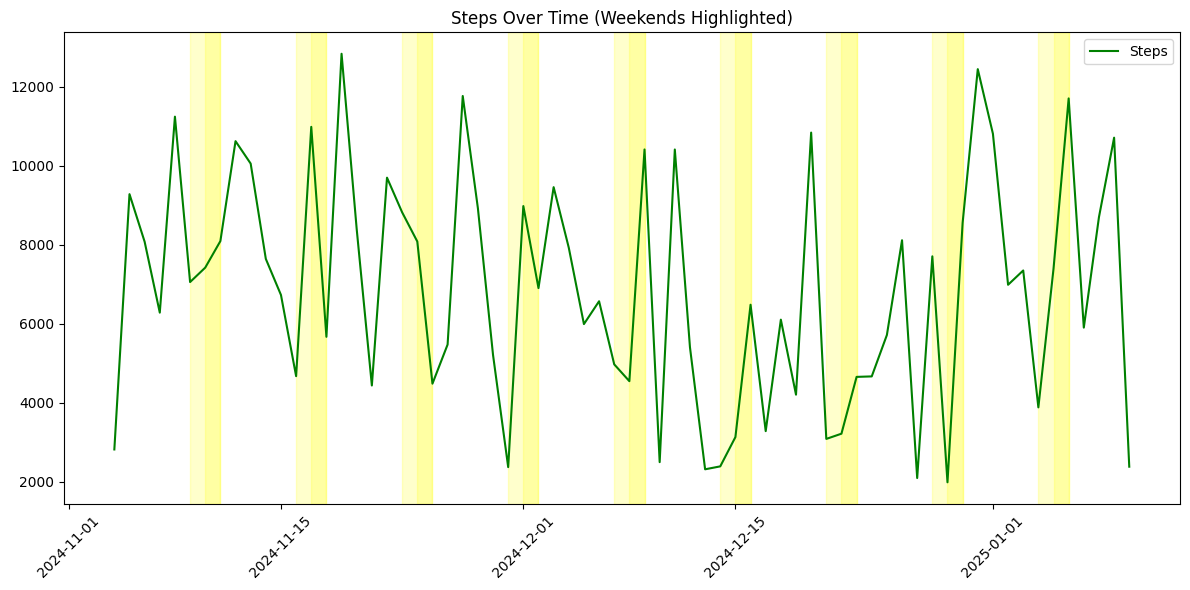

In [94]:
import matplotlib.dates as mdates

print("\nPlotting Steps Over Time With Weekends Highlighted...")

df_weekend = merged_df.dropna(subset=["Date", "steps"]).copy()

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(df_weekend["Date"], df_weekend["steps"], label="Steps", color="green")

unique_dates = df_weekend["Date"].unique()
for d in unique_dates:
    dt = pd.to_datetime(d)

    if dt.weekday() == 5:  # Saturday
        start_day = dt.replace(hour=0, minute=0, second=0)
        end_day = start_day + pd.Timedelta(days=1, hours=23, minutes=59, seconds=59)
        ax.axvspan(start_day, end_day, color="yellow", alpha=0.2)
    elif dt.weekday() == 6:  # Sunday
        start_day = dt.replace(hour=0, minute=0, second=0)
        end_day = start_day + pd.Timedelta(hours=23, minutes=59, seconds=59)
        ax.axvspan(start_day, end_day, color="yellow", alpha=0.2)

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.title("Steps Over Time (Weekends Highlighted)")
plt.legend()
plt.tight_layout()
plt.show()


This graph shows us some daily fluctuations.


*  As can be seen, the **green line** shows how my step count varies day to day (Notice the spikes and dips!).
*   The **yellow lines** highlights weeknd, in other words Saturdays and Sundays. This helps comparing my step behavior on weekends vs. weekdays.

The higher the spikes on the yellow stripes, the stronger it indicates that I am in fact more active on weekends when I'm off school. The dips on the yellow stripes may indicate the weekends that I am resting and focusing on my hobbies.

By scanning the yellow stripes, one can spot whether my steps consistently jump or drop on weekends. This may be a sign of a potential pattern. When the green lines peaks around the lines, it suggests a weekend effect on my physical activity. *But since the graph is constantly flactuating, there are no signs that weekends have positive impact on my physical activities.*

# **Part 12: Hypothesis Testing (Correlation)**

In [101]:
print("\nHypothesis Testing: Screen Time vs. Steps")

valid_data = merged_df.dropna(subset=["total_screen_time_minutes", "steps"])
corr, pval = pearsonr(valid_data["total_screen_time_minutes"], valid_data["steps"])
print(f"Pearson correlation = {corr:.4f}, p-value = {pval:.4g}")
if pval < 0.05:
    print("Might indicate a possible significant correlation (alpha=0.05).")
else:
    print("Not statistically significant at alpha=0.05.")

print("""
CAUTION: correlation does NOT mean causation.
A significant correlation only shows these two variables move together, but just because it happens might not mean that one causes the other.
""")



Hypothesis Testing: Screen Time vs. Steps
Pearson correlation = 0.2798, p-value = 0.02084
Might indicate a possible significant correlation (alpha=0.05).

CAUTION: correlation does NOT mean causation. 
A significant correlation only shows these two variables move together, but just because it happens might not mean that one causes the other.



# **Concluding Summary**
1. I had successfully** loaded** four separate JSON datasets(which are deadlines, iPhone screen time, laptop screen time, and steps/kcal) then **transformed** them into tidy Pandas DataFrames, and **merged** them into one master DataFrame (merged_df).

2. Then I converted iPhone screen time from "HH:MM:SS", and laptop usage from strings like "2 hours 34 minutes" into minutes. Steps and calories were already numeric.

3. By standardizing columns, I ensured that each variable is on the same scale (with mean=0, std=1). **A correlation heatmap** then quantifies how strongly/loosely they relate each other.

Time-Series Visualizations:
4. **Steps vs. iPhone & Laptop** plot, on dual y-axes, shows if there’s a pattern such as, do steps go down when iPhone/laptop usage goes up?

5. **Deadlines vs. iPhone & Laptop** might indicate that academic/work deadlines cause higher laptop usage or reduce phone usage.

6. **Weekend Highlighting** clarifies if weekends systematically change my step count.

7. **Hypothesis Testing:** A Pearson correlation test with p-value < 0.05 means there is a possible linear relationship, but not necessarily causation.
For example, I have  found a correlation ~0.28 between iPhone screen time and steps, suggesting a slightly positive relationship, which somewhat rise together, or at least do oppose each other in a strong way.

# **Conclusion**
My analysis gives me a wholistic view of how my screen time (phone and laptop) intersects with my daily steps and deadlines. While certain correlations may appear *statistically significant*, we must remember that“correlation is not causation.” I have patterns and interesting relationships but might need a further controlled study or additional data to conclude the cause-effect relation.







